# Recurrent Neural Networks: Example 1 - Clothing Sales Dataset

In this noteboook a real time series dataset is used to build a model and forecast future values.

The dataset was downloaded from the FRED website with data on **Retail Sales: Clothing and Clothing Accessory Stores (Not Seasonally Adjusted)**:

[https://fred.stlouisfed.org/series/RSCCASN](https://fred.stlouisfed.org/series/RSCCASN)

Note that the COVID-19 changes the expected course of the data; therefore, I used the CSV from J.M. Portilla's course, which can be found in the `data` folder:

`../../data/RSCCASN.csv`

`git_repositories/data_science_python_tools/data/RSCCASN.csv`

Important note: it makes sense to have date information instead of date strings to fully handle the time series.
Therefore, often date strings need to be converted into datetime type.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
# We load the dataset
# We convert the date string to datetime type on the fly
# and be set that column to be the index
df = pd.read_csv('../../data/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [10]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [14]:
# We change the name of the column so that it's easier to remember
# Note that it contains sales in millions by day
df.columns = ['Sales']

In [15]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

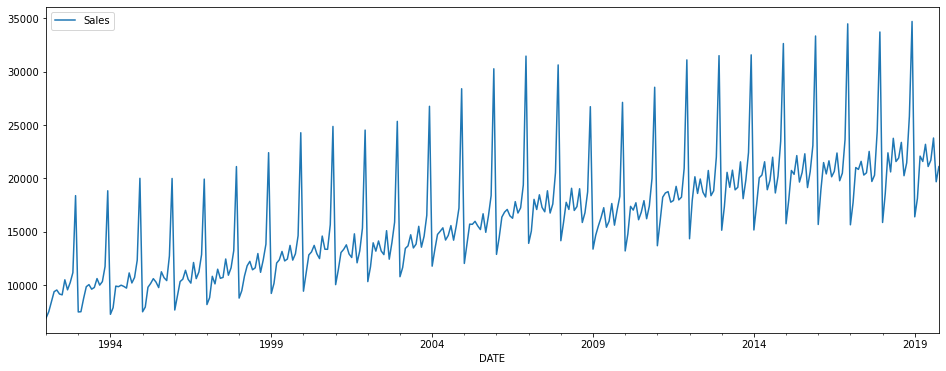

In [16]:
df.plot(figsize=(16,6))